# Advanced Machine Learning

## Assignment #4

<a href="https://drive.google.com/file/d/18_MF9RTCCGBTs2xL3NtOgQzIUAhFSL3r/view?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width=150 align='left'/>
</a>

### Packages

In [0]:
%tensorflow_version 2.x
!pip install -q keras==2.3.0
#!pip install -q matplotlib==3.0.1
!pip install -q livelossplot

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 2.7MB/s 


In [0]:
# Colab and download data
import gc
from google.colab import drive
import json
import os
import zipfile

# Data viz and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# DL 
import tensorflow as tf
import cv2                  
from random import shuffle  
from PIL import Image
import random as rn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold, RFE

from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from IPython.display import clear_output
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


### Prepare env for Colab

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('gdrive/My Drive/kaggle.json', 'r') as f:
  data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = str(data['username'])
  os.environ['KAGGLE_KEY'] = str(data['key'])   

In [0]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 443M/450M [00:11<00:00, 59.0MB/s]
100% 450M/450M [00:11<00:00, 42.2MB/s]


In [0]:
zip_ref = zipfile.ZipFile('flowers-recognition.zip', 'r')
zip_ref.extractall()
zip_ref.close()

print(os.listdir('flowers'))

['tulip', 'sunflower', 'rose', 'dandelion', 'daisy', 'flowers']


### Import data

Ci prepariamo ad importare i dati e definiamo una serie di funzioni per importare le immagini, etichettarle con il nome della cartella in cui sono contenute e ritagliarle tutte alla medesima grandezza.

Il dataset scelto conta 4323 immagini rappresentanti 5 classi di fiori: girasoli, tulipani, rose, denti di leone e margherite in formato a colori RGB. Ogni immagine possiede dimensioni diverse e per questo è necessario riformattarle in input alla stessa dimensione.

In [0]:
X = []
Z = []
IMG_SIZE = 224
FLOWER_DAISY_DIR = 'flowers/daisy'
FLOWER_SUNFLOWER_DIR = 'flowers/sunflower'
FLOWER_TULIP_DIR = 'flowers/tulip'
FLOWER_DANDI_DIR = 'flowers/dandelion'
FLOWER_ROSE_DIR = 'flowers/rose'

In [0]:
def assign_label(img, flower_type):
    return flower_type

In [0]:
def make_data(flower_type, DIR):
    print("Importing {flower}...".format(flower = flower_type))
    
    for img in os.listdir(DIR):
        try:
            label = assign_label(img, flower_type)
            path = os.path.join(DIR, img)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
    print("### Done ###")

In [0]:
make_data('Daisy', FLOWER_DAISY_DIR)
make_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_data('Tulip', FLOWER_TULIP_DIR)
make_data('Dandelion', FLOWER_DANDI_DIR)
make_data('Rose', FLOWER_ROSE_DIR)
print("Imported {n} images".format(n = len(X)))

Importing Daisy...
### Done ###
Importing Sunflower...
### Done ###
Importing Tulip...
### Done ###
Importing Dandelion...
### Done ###
Importing Rose...
### Done ###
Imported 4323 images


### Some inspections

Visualizziamo la distribuzione delle labels riguardo le immagini dei nostri fiori ed alcune delle immagini appena importate.

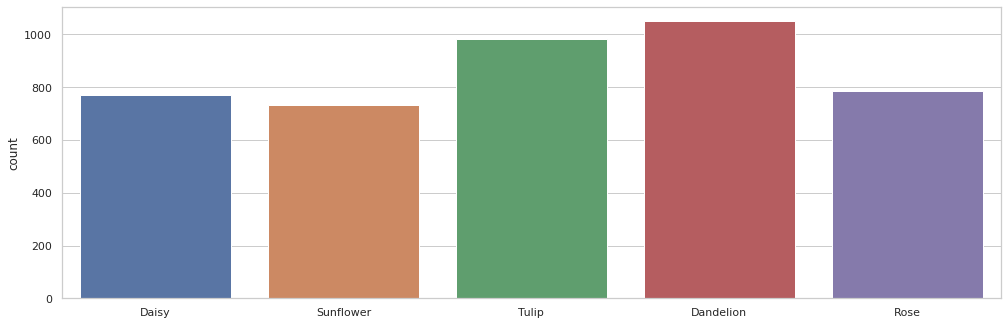

In [0]:
plt.figure(figsize = (15, 5))
sns.countplot(Z)

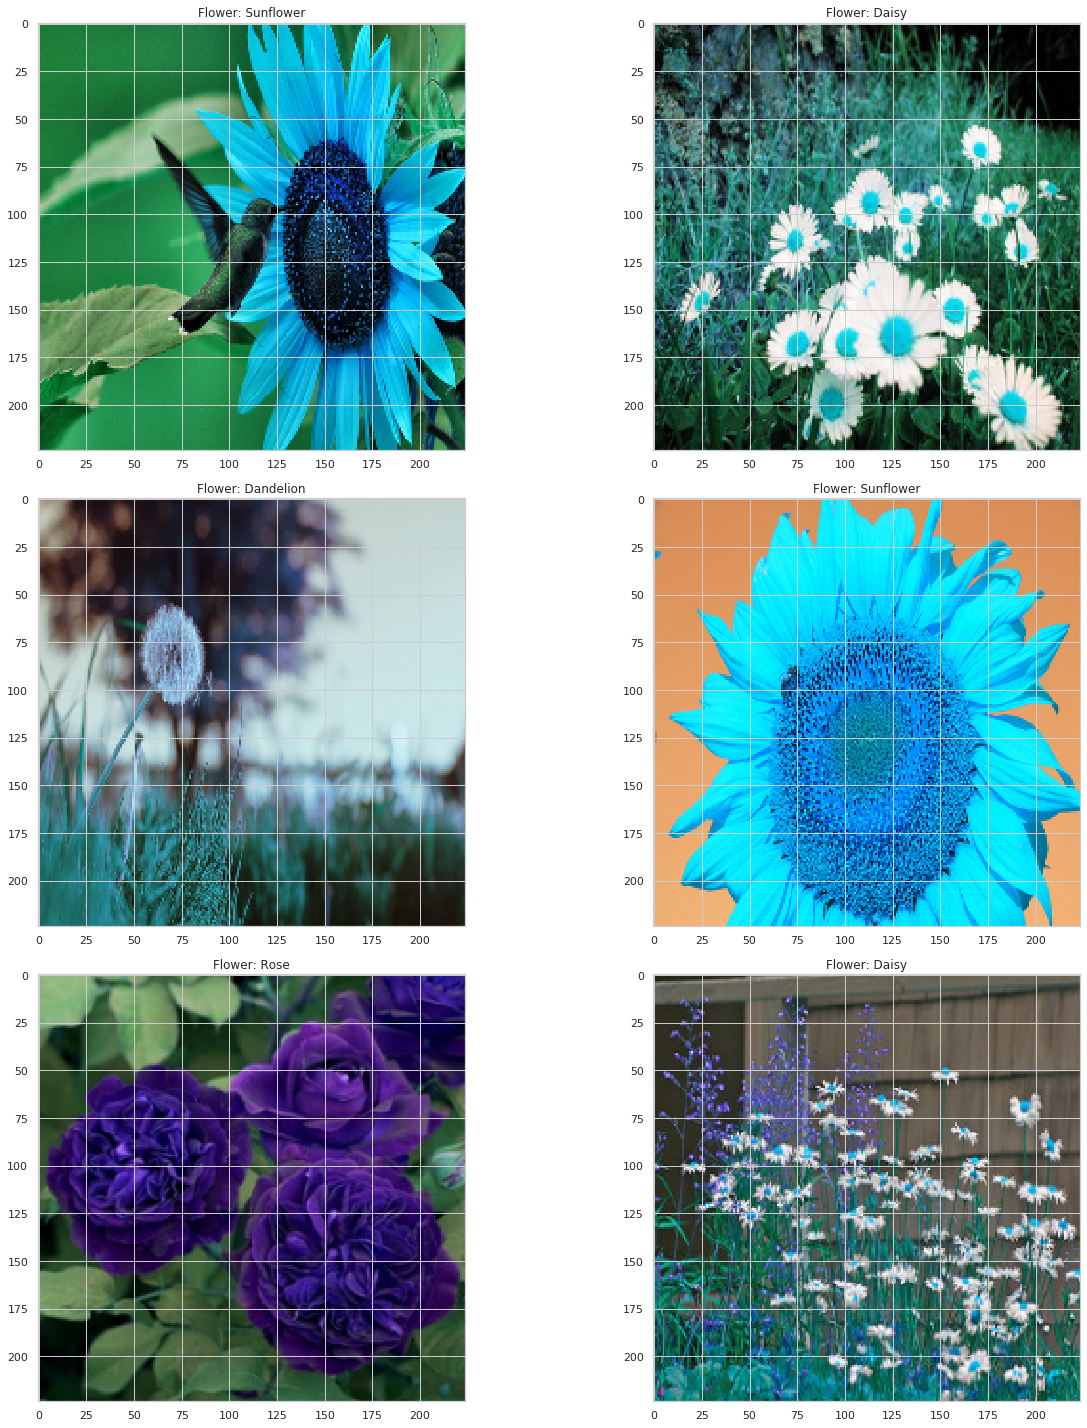

In [0]:
fig, ax = plt.subplots(3, 2, figsize = (30, 30))
fig.set_size_inches(20, 20)
for i in range(3):
    for j in range (2):
        l = rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: '+ Z[l])
        
plt.tight_layout()

### Preprocessing and feature extraction

Formattiamo le nostre label in formato numerico e riduciamo la nostra lista di immagini ad un array di immagini. 

Successivamente preprocessiamo le nostre immagini in modo coerente con il preprocessing che hanno ricevuto le immagini del dataset imagenet su cui è stata addestrata la nostra rete.

Infine definiamo una funzione che estragga le features dalle nostre immagini troncando la rete ad un determinato layer scelto da noi.

In [0]:
le = LabelEncoder()
Y = le.fit_transform(Z)
X = np.array(X)

# Eliminiamo vecchie etichette
del Z

In [0]:
# Shuffle
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]

In [0]:
img_data = preprocess_input(X)
img_data.shape

# Eliminiamo immagini non preprocessate
del X


Definiamo la nostra funzione. Al suo interno viene definito un nuovo modello troncando la nostra rete arbitrariamente ad un dato layer. Così facendo speriamo di effettuare una feature extraction significativa.

In [0]:
def extract_features(name_layer, data):
  base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224,224,3),
                   pooling='avg')
  dims = []
  for dim in base_model.get_layer(name = name_layer).output_shape:
    if dim == None:
      pass
    else:
      dims.append(dim)
  reshaping = np.prod(np.array(dims))

  tmp = Model(base_model.input, base_model.get_layer(name = name_layer).output)
  tmp.summary()


  features = tmp.predict(data)
  features = features.reshape((features.shape[0], reshaping))
  print("\nDims {}".format(features.shape))
  del dims, reshaping, tmp, base_model

  return features

A questo punto per ognuna delle nostre immagini abbiamo estratto una serie di features che ora sottometteremo a classificatori classici per verificarne le prestazioni.

### Classification model

Dopo numerosi tentativi si è deciso di utilizzare come classificatore per le features estratte una Support Vector Machine. Dalle prove effettuate sembra operare piuttosto bene e rapidamente, oltre a raggiungere le migliori performances in classificazione se comparato con k-NN e RandomForest.

Data la scelta della Support Vector Machine si rende necessario scalare i nostri dati tra 0 e 1 per poi procedere ad una features selection attraverso PCA. In questo modo si tenta di limitare l'impatto delle numerose features sulla necessità di calcolo del modello.

Estraiamo le nostre features

In [0]:
vgg16_feature = extract_features(name_layer = "block5_pool",
                                 data = img_data)

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Il primo livello scelto per estrarre le nostre features è il penultimo, ovvero il **block5_pool**, l'ultimo layer di max pooling della rete. A questo punto della rete le nostre immagini hanno raggiunto un formato 7x7x512, quindi estremamente approfondito grazie al numeroso numero di filtri ma anche molto ristretto date le dimensioni dell'immagine. A questo punto della rete, quindi, per ogni immagine vengono prodotte 25088 features.

In [0]:
# Scaliamo le features
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vgg16_feature)

del vgg16_feature

In [0]:
data_rescaled.shape

(4323, 25088)

In [0]:
#Plotting the Cumulative Summation of the Explained Variance
def plot_pca(data):
  pca = PCA(n_components = min(data.shape[0], data.shape[1]), copy = False).fit(data)
  plt.figure(figsize = (15,5))
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of Components')
  plt.ylabel('Variance (%)') #for each component
  plt.title('Images Dataset Explained Variance')
  plt.show()
  del pca

Plottiamo il risultato della PCA in modo da verificare la somma cumulata della varianza spiegata al crescere delle features selezionate così da poter scegliere un ammontare sensato di features da selezionare.

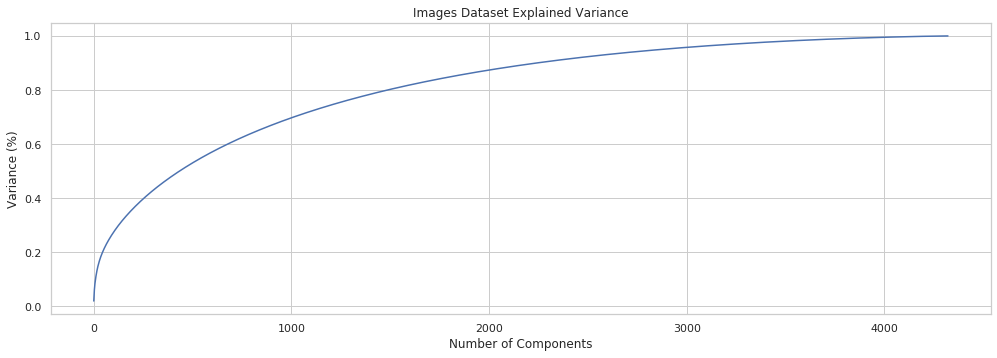

In [0]:
plot_pca(data = data_rescaled)

In [0]:
pca = PCA(0.8, copy = False)
dataset = pca.fit_transform(data_rescaled)

del pca
del data_rescaled

dataset.shape

(4323, 1500)

Decidiamo di selezionare 1500 features cosi da raccogliere circa l'80% della varianza spiegata ma riducendo drasticamente l'ammontare di features utilizzate così da preservare spazio in memoria e velocità di calcolo del modello.

Una volta preparati i nostri dati procediamo alla divisione in training set e test set.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

del dataset

#### SVM block5_pool

Avviamo una Grid Search Cross Validation per trovare i valori migliori di C e gamma per la nostra Support Vector Machine. In prove precedenti si è già verificato che il miglior kernel è l'rbf.

In [0]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}
svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

In [0]:
svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 5
Best gamma value:auto

              precision    recall  f1-score   support

           0      0.835     0.844     0.839       192
           1      0.915     0.905     0.910       263
           2      0.787     0.888     0.835       196
           3      0.853     0.755     0.801       184
           4      0.881     0.870     0.875       246

    accuracy                          0.858      1081
   macro avg      0.854     0.852     0.852      1081
weighted avg      0.859     0.858     0.857      1081



La classificazione raggiunge performances piuttosto buone considerando anche il formato delle varie foto. Non si tratta infatti di foto molto pulite, spesso il soggetto è tagliato, o presente in grande quantità e ciò potrebbe portare ad una cattiva classificazione.

Dai risultati del classification report sul test set sembrerebbe proprio che la classe 1, ovvero il dente di leone, sia quello classificato nel modo più accurato, cioò è probabilmente dovuto alla sua particolare struttura o alla natura stessa delle immagini che lo ritraggono, mediamente più pulite.

Il risultato peggiore invece si osserva sulle rose.

#### SVM block4_pool

Procediamo a questo punto con un diverso livello di estrazione delle features. Risalendo la rete ci fermiamo al layer **block4_pool**, sempre un layer di max pooling al quale livello le immagini hanno raggiunto un formato 14x14x512. A questo punto della rete per ogni immagine vengono prodotte 100352 features, un numero considerevole.

In [0]:
vgg16_feature = extract_features(name_layer = 'block4_pool',
                                 data = img_data)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# Scale delle features
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vgg16_feature)

del vgg16_feature

Già a questo punto la banale rappresentazione della somma cumulata della varianza spiegata diventa molto onerosa a livello di memoria.

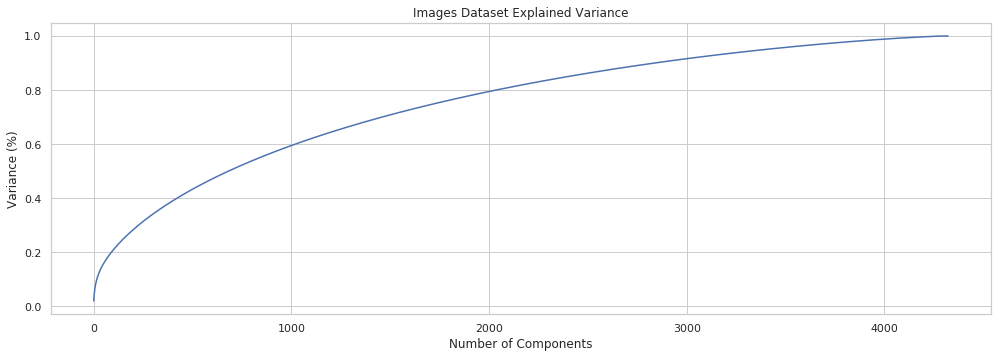

In [0]:
plot_pca(data_rescaled)

Per raggiungere lo stesso ammontare di varianza spiegata rispetto a prima, ovvero l'80% è per noi necessario estrarre 2000 componenti con la PCA.

In [0]:
pca = PCA(0.8, copy = False)
dataset = pca.fit_transform(data_rescaled)
dataset.shape

del pca
del data_rescaled

In [0]:
x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

del dataset

In [0]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}
svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 5
Best gamma value:auto

              precision    recall  f1-score   support

           0      0.778     0.823     0.800       192
           1      0.877     0.871     0.874       263
           2      0.798     0.806     0.802       196
           3      0.818     0.804     0.811       184
           4      0.866     0.837     0.851       246

    accuracy                          0.832      1081
   macro avg      0.827     0.828     0.828      1081
weighted avg      0.833     0.832     0.832      1081



Le prestazioni sembrerebbero essere sostanzialmente identiche.

#### SVM block3_pool

Per eseguire questo livello potrebbe essere necessario riavviare il runtime per pulire la memoria RAM ed evitare una sua saturazione.

In [0]:
vgg16_feature = extract_features(name_layer = 'block3_pool',
                                 data = img_data)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

A questo livello la rappresentazione è di 28x28x256 per ogni immagine. Per ogni istanza sono quindi raccolte 200704 features.

In [0]:
del x_train, x_test, y_train, y_test, img_data, y_pred

In [0]:
# Scale delle features
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vgg16_feature)

del vgg16_feature

In [0]:
pca = PCA(0.8, copy = False)
dataset = pca.fit_transform(data_rescaled)
dataset.shape

del pca, data_rescaled

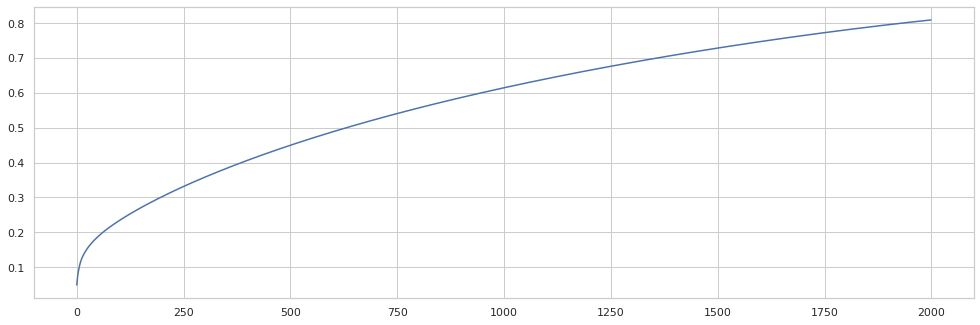

In [0]:
plt.figure(figsize = (15,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Anche in questo caso estraendo 2000 componenti riusciamo a recuperare l'80% della varianza spiegata.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(dataset,
                                                    Y,
                                                    test_size = .25,
                                                    stratify = Y) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

del dataset

In [0]:
param_grid = {'C': [5, 10, 15], 'gamma': ['auto', 'scale']}
svm = GridSearchCV(SVC(class_weight = 'balanced'),
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1)

svm.fit(x_train, y_train)
print("Best C value: {C}\nBest gamma value:{gamma}\n".format(C = svm.best_params_['C'],
                                                           gamma = svm.best_params_['gamma']))

y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))

Best C value: 10
Best gamma value:scale

              precision    recall  f1-score   support

           0      0.756     0.677     0.714       192
           1      0.841     0.802     0.821       263
           2      0.783     0.719     0.750       196
           3      0.750     0.815     0.781       184
           4      0.727     0.821     0.771       246

    accuracy                          0.772      1081
   macro avg      0.771     0.767     0.768      1081
weighted avg      0.774     0.772     0.771      1081



Le prestazioni sembrerebbero peggiorare sensibilmente, probabilmente questo è dovuto al fatto che risalendo la rete l'astrazione delle features estratte aumenta e, per questo specifico tipo di immagini, causerebbe un peggioramento nella classificazione.